# Laboratorio 2   --- Marcelo Cena

# Objetivos

En este práctico tendrán que integrar en la notebook el sistema de recomendación basado en contenido que se propone en http://nbviewer.jupyter.org/github/khanhnamle1994/movielens/blob/master/Content_Based_ and_Collaborative_Filtering_Models.ipynb.

Entrega
Entregar un notebook documentado a través de slack, antes del día 7 de septiembre.


## Datasets

Usaremos un dataset extraido de https://labrosa.ee.columbia.edu/millionsong/ que consiste en datos de canciones extraidos de diferentes sitios y el rating que los usuarios le dan a las mismas. Este dataset contiene dos archivos, uno guardado en formato csv, contiene metadatos de cada canción, como id, título, disco, artista y año, de los cuales vamos a utilizar solamente los datos correspondientes a los titulos y disco para intentar hacer un clustering de las canciones en relación a las palabras en común. Como en la version anterior conseguimos un gran cluster con muchas canciones y todos los otros con no mas de 500, vamos a probar concatenando el nombre de la cancion con el nombre del disco .



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import wordcloud
from wordcloud import WordCloud, STOPWORDS

## Loading of Data

Cargamos el dataset, extraemos los datos de titulos y albumes y votos de los oyentes, como en el laboratorio anterior.
Unimos los dos datasets y le agregamos una columna cancion+album y despues recortamos el dataset (de 2 millones a 40 mil).
Despues utilizamos TfidfVectorizer para representarlos.

In [2]:
canciones = pd.read_csv('data/song_data.csv')
#display(canciones.head(2))
canciones_df = pd.read_table('data/Songs_10000.txt',header=None)
canciones_df.columns = ['user_id', 'song_id', 'listen_count']
#display(canciones_df.head(2))

song_df1 = pd.merge(canciones_df, canciones.drop_duplicates(['song_id']), on="song_id", how="left")

song_df= song_df1.head(35000)
song_df["tag"] = song_df["title"] + " - " + song_df["release"]
display(song_df.head(5))

C:\Users\marcelo.cena\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,user_id,song_id,listen_count,title,release,artist_name,year,tag
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Thicker Than Water
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,Entre Dos Aguas - Flamenco Para Niños
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,Stronger - Graduation
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,Constellations - In Between Dreams
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,Learn To Fly - There Is Nothing Left To Lose


Para facilitar la implentación de las tecnicas de recomendación, a las variables de event_type se les asigna un valor cuantitativio el cual se agrega como un dato mas en el dataset_2.

In [3]:
display(canciones.head(10))
display(canciones_df.head(100))

display(song_df.head(40))

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0
5,SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",Berwald: Symphonies Nos. 1/2/3/4,David Montgomery,0
6,SOQVRHI12A6D4FB2D7,We Have Got Love,Strictly The Best Vol. 34,Sasha / Turbulence,0
7,SOEYRFT12AB018936C,2 Da Beat Ch'yall,Da Bomb,Kris Kross,1993
8,SOPMIYT12A6D4F851E,Goodbye,Danny Boy,Joseph Locke,0
9,SOJCFMH12A8C13B0C2,Mama_ mama can't you see ?,March to cadence with the US marines,The Sun Harbor's Chorus-Documentary Recordings,0


,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1


,user_id,song_id,listen_count,title,release,artist_name,year,tag
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Thicker Than Water
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,Entre Dos Aguas - Flamenco Para Niños
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,Stronger - Graduation
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,Constellations - In Between Dreams
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,Learn To Fly - There Is Nothing Left To Lose
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,Héroes del Silencio,2007,Apuesta Por El Rock 'N' Roll - Antología Audio...
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,Paper Gangsta,The Fame Monster,Lady GaGa,2008,Paper Gangsta - The Fame Monster
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1,Stacked Actors,There Is Nothing Left To Lose,Foo Fighters,1999,Stacked Actors - There Is Nothing Left To Lose
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,Sehr kosmisch,Musik von Harmonia,Harmonia,0,Sehr kosmisch - Musik von Harmonia
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1,Heaven's gonna burn your eyes,Hôtel Costes 7 by Stéphane Pompougnac,Thievery Corporation feat. Emiliana Torrini,2002,Heaven's gonna burn your eyes - Hôtel Costes 7...


In [4]:
import keras

print(keras.__version__)

C:\Users\marcelo.cena\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.2.2


# Análisis exploratorio

### Showing the most popular songs in the dataset¶


In [5]:
song_grouped = song_df.groupby(['title']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'title'], ascending = [0,1])

,title,listen_count,percentage
5958,Sehr kosmisch,135,0.385714
1714,Dog Days Are Over (Radio Edit),130,0.371429
8253,You're The One,122,0.348571
7580,Undo,119,0.340000
5661,Revelry,118,0.337143
5949,Secrets,109,0.311429
2251,Fireflies,90,0.257143
2990,Horn Concerto No. 4 in E flat K495: II. Romanc...,89,0.254286
7379,Tive Sim,78,0.222857
4355,Marry Me,76,0.217143


## Armamos una nube de palabras con los trítulos de los temas

C:\Users\marcelo.cena\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


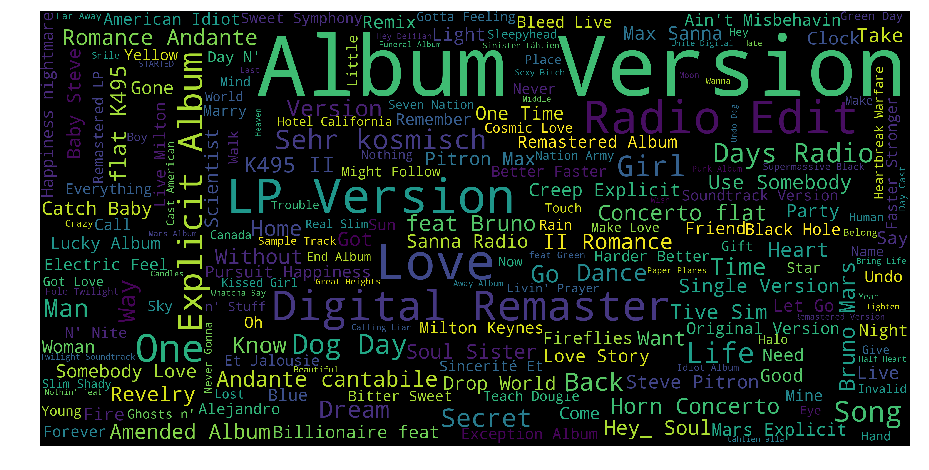

In [6]:
song_df['title'] = song_df['title'].fillna("").astype('str')
title_corpus = ' '.join(song_df['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Se pueden apreciar los titulos mas comunes, obviamente aparecen Album y Version ademas de las palabras Radio, edit, Digital y Remaster

### Ratings

Ahora vamos a ver que hay de los ratings

In [7]:
song_df['listen_count'].describe()

count    35000.000000
mean         3.054971
std          7.537485
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        796.000000
Name: listen_count, dtype: float64

C:\Users\marcelo.cena\AppData\Roaming\Python\Python35\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


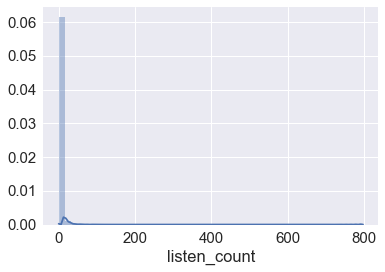

In [8]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Display distribution of rating
sns.distplot(song_df['listen_count'].fillna(song_df['listen_count'].median()))


Podemos obvservar que la mayoria de las canciones fue escuchada pocas veces con 4, seguidos de 5 y 3. Muy pocas fueron oidas muchas veces. No esta distribuido uniformemente.

### Autores

Una suposición básica es que los autores suelen escribir canciones generalmente parecidos. Vamos a mostrar en una tabla cuales son los autores que mas escribieron.

C:\Users\marcelo.cena\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


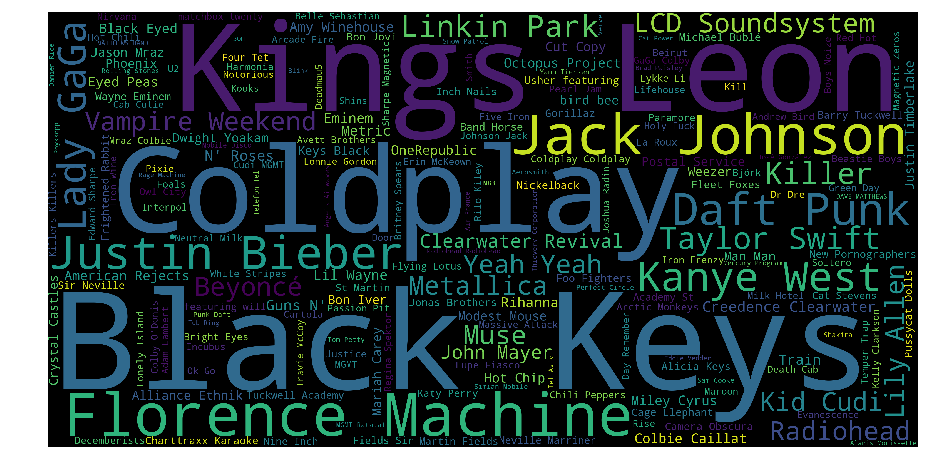

In [9]:
song_df['artist_name'] = song_df['artist_name'].fillna("").astype('str')
title_corpus = ' '.join(song_df['artist_name'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Aquí, claramente, se observa que artistas como Jack Johnson, Black Keys y Kings Leon son los mas escuchados, seguidos de cerca por Florence Machine y Justin Bieber 

### Tema + Disco

Otra suposición básica es que las diskeras suelen agrupar canciones relacionadas en los mismos discos. Vamos a mostrar en una tabla si tales relaciones se cumplen.

C:\Users\marcelo.cena\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


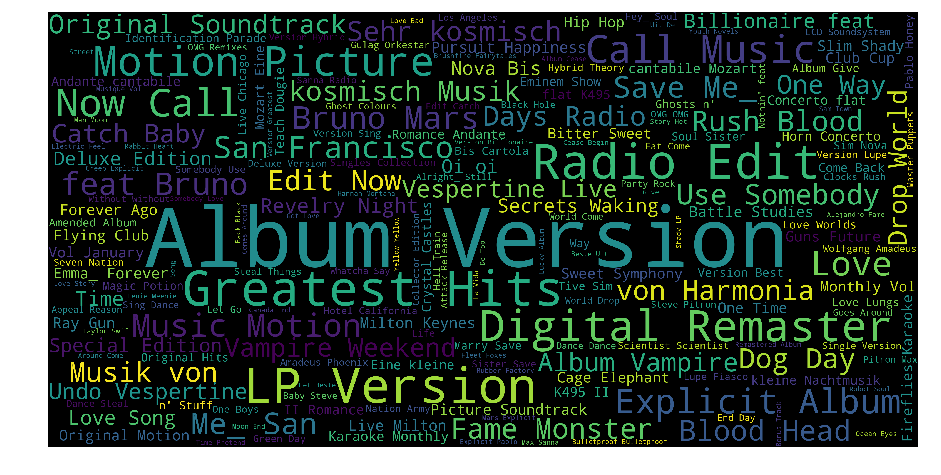

In [10]:
song_df['tag'] = song_df['tag'].fillna("").astype('str')
title_corpus = ' '.join(song_df['tag'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

acá vemos un poco mas de dispersion, las palabras mas usadas son Album y Version seguidos por Greatest Hits, Radio Edit, LP Version

- ** Vamos a aplicar TfidfVectorizer a los titulos y quitarle las stop words a ver que sucede **

## Hay 2 Tipos de motores de recomendación

### 1. Basados en contenido

El recomendador basado en el contenido se basa en la similitud de los elementos que se recomiendan. La idea básica es que si te gusta un artículo, también te gustará un artículo "similar". Por lo general, funciona bien cuando es fácil determinar el contexto / propiedades de cada elemento.

Un recomendador basado en contenido funciona con datos que el usuario proporciona, en este caso las clasificaciones de las peliculas de MovieLens. En función de esos datos, se genera un perfil de usuario, que luego se utiliza para hacer sugerencias al usuario de nuevas pelicuas. A medida que el usuario proporciona más calificaciones, el motor se vuelve cada vez más preciso.

### 2. Filtrado colaborativo

El "Collaborative Filtering Recommender" se basa completamente en el comportamiento pasado y no en el contexto. Más específicamente, se basa en la similitud de preferencias, gustos y elecciones de dos usuarios. Analiza cuán similares son los gustos de un usuario a otro y hace recomendaciones sobre la base de eso.

Por ejemplo, si al usuario A le gustan las películas 1, 2, 3 y al usuario B le gustan las películas 2,3,4, entonces tienen intereses similares y A debería gustarle a la película 4 y B debería gustarle la película 1. 

En general, el filtrado colaborativo es el caballo de batalla de los motores de recomendación. El algoritmo tiene una propiedad muy interesante de poder hacer el aprendizaje de características por sí mismo, lo que significa que puede comenzar a aprender por sí mismo qué características usar. 

Se puede dividir en  Filtrado colaborativo basado en memoria  y  Filtrado colaborativo basado en modelo.

![rec-systems](rec-systems.png)

## Modelo de recomendación basado en el contenido

### Teoría

Los conceptos de Frecuencia de término (TF) y Frecuencia inversa de documento (IDF)
se utilizan en sistemas de información y también en mecanismos de filtrado basados
en contenido (como un recomendador basado en contenido).
Se usan para determinar la importancia relativa de un documento / artículo / noticia / película, etc.

TF es simplemente la frecuencia de una palabra en un documento. 
IDF es la inversa de la frecuencia del documento entre todo el corpus de documentos. 
TF-IDF se utiliza principalmente por dos motivos: supongamos que buscamos 
    
"** los resultados de los últimos juegos europeos de Futbol **" en Google.

Es cierto que las palabras como "el", "los", "de" ocurrirán con más frecuencia que "** juegos europeos de Futbol **" 
pero la importancia relativa de ** juegos europeos de Futbol ** es más alta que el punto de vista de la búsqueda.
En tales casos, la ponderación TF-IDF niega el efecto de las palabras de alta frecuencia para determinar 
la importancia de un elemento (documento).



### Implementación del un Montor de Recomendacion basado en contenido.
Utilizamos la Similitud coseno para calcular una cantidad numérica que denote la similitud entre dos películas. Ya que hemos utilizado el Vectorizador TF-IDF, al calcular el Producto Punto, nos dará directamente el Puntaje de Similaridad. Utilizaremos kernel lineal de sklearn.

In [11]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(song_df['tag'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

C:\Users\marcelo.cena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [12]:
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:
print('Veamos por ejemplo cuáles canciones fueron oidas por el usuario con ID= b80344d063b5ccb3212f76538f3d9e43d87dca9e:')

song_df[song_df.user_id=='b80344d063b5ccb3212f76538f3d9e43d87dca9e'][['tag','listen_count']].sort_values(by='listen_count', ascending=False).head(3)


Veamos por ejemplo cuáles canciones fueron oidas por el usuario con ID= b80344d063b5ccb3212f76538f3d9e43d87dca9e:


,tag,listen_count
43,Moonshine - Thicker Than Water,8
16,Behind The Sea [Live In Chicago] - Live In Chi...,6
14,I?'m A Steady Rollin? Man - Diggin' Deeper Vol...,5


- **Comportamiento de dos usuarios**

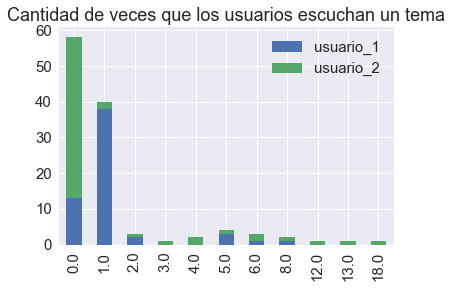

In [14]:
index = song_df.listen_count
user_1 = song_df[song_df.user_id=='b80344d063b5ccb3212f76538f3d9e43d87dca9e']['listen_count']

user_1 = pd.Series(user_1, name='usuario_1')
user_2= song_df[song_df.user_id=='4bd88bfb25263a75bbdd467e74018f4ae570e5df']['listen_count']
user_2 = pd.Series(user_2, name='usuario_2')
user_1_2=pd.concat([user_1 ,user_2],axis=1).fillna(0)


result = user_1_2.apply(pd.value_counts).fillna(0)

result.plot(y=['usuario_1', 'usuario_2'],kind='bar', stacked=True,title='Cantidad de veces que los usuarios escuchan un tema')


La barra correspondiente a **0.0** muestra que el **usario_1** tuvo menor interacción con los temas que el **usuario_2**, sin embargo se observa que los dos usuarios tienden a tener  gustos disimiles teninedo en cuanta la cantidaad de veces que coinciden en un tema, es decir, sus gustos musicales no son parecidos.
Adicionalmente, vemos que el **usuario_2** tiende a escuchar muchas veces (12-13-18) algunos temas, mientras que el **usuario_1** tiende a escuchar una sola vez distintos temas (alrededor de 35).

# Recomendación

- **Recomendación Basada en Contenido**

Para implementar el recomendador basado en el contenido nos limitaremos en  usar el dataset_1  usando la similitud de los titulos de los articulos y el texto de los mismos, dado que la idea básica es que si te gusta un artículo, también te gustará un artículo "similar".

**Implementación**

Como los artículos tienen distintos idiomas, obesrvo como se distribuyen los mismos.

In [15]:
idio_en = song_df['tag']
idio_en.head(3)

0            The Cove - Thicker Than Water
1    Entre Dos Aguas - Flamenco Para Niños
2                    Stronger - Graduation
Name: tag, dtype: object

Entonces generamos un dataset que contenga solo temas musicales en idioma inglés.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(idio_en)
tfidf_matrix.shape

C:\Users\marcelo.cena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(35000, 48036)

La similitud numérica entre los artículos:

In [17]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Vemos que existe valores igual a 1 fuera de la diagonal, esto se debe a que los artículos se repiten en el dataset.

Usando la matriz de similitud de coseno pairwise para todos los artículos.
Veamos los 10 artículos más similares en función de la puntuación de similitud del coseno.

In [18]:
# Build a 1-dimensional array with movie titles
titulos = song_df['tag']
indices = pd.Series(song_df.index, index=song_df['tag'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def text_recommendations(titulo):
    idx = indices[titulo]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[0], reverse=True)
    sim_scores = sim_scores[1:11]
    canciones_indices = [i[0] for i in sim_scores]
    return titulos.iloc[canciones_indices]


Vemos como resulta la recomendación basada en contenido para un artículo en particular

In [19]:
display(song_df.tag[4])
text_recommendations(song_df.tag[4])


'Learn To Fly - There Is Nothing Left To Lose'

14    I?'m A Steady Rollin? Man - Diggin' Deeper Vol...
13    Clarity - As/Is: Cleveland/Cincinnati_ OH - 8/...
12                    Love Shack - Original Hits - Rock
11    I'll Be Missing You (Featuring Faith Evans & 1...
10                       Let It Be Sung - If I Had Eyes
9     Heaven's gonna burn your eyes - Hôtel Costes 7...
8                    Sehr kosmisch - Musik von Harmonia
7        Stacked Actors - There Is Nothing Left To Lose
6                      Paper Gangsta - The Fame Monster
5     Apuesta Por El Rock 'N' Roll - Antología Audio...
Name: tag, dtype: object

In [20]:
display(song_df.tag[1003])
text_recommendations(song_df.tag[1003])

'Fix You - X & Y'

42                         Right Back - 40oz To Freedom
41                       City Love - Any Given Thursday
40                                Sun Giant - Sun Giant
39       Bigger Isn't Better - Born on the Wrong Planet
38                      Trani - Youth And Young Manhood
37                    He Doesn't Know Why - Fleet Foxes
36    Come Back To Bed - As/Is:  Philadelphia_ PA/Ha...
35            Generator - There Is Nothing Left To Lose
34                                Drive - Make Yourself
33                 Are You In? - Monuments And Melodies
Name: tag, dtype: object

Como no pudimos utilizar todo el dataset por razones de memoria, la informacion aquí extraida es absolutamente sesgada ya que estamos tomando las primeras 30000 filas del archivo. Podríamos haber probado haciendo una seleccion aleatoria de las filas del archivo, pero igual vamos a tener el problema de la pérdida de variabilidad.
A pesar de esto, vemos que hay una buena concordancia en la similitud de temas utilizando titulo de la cancion mas nombre del album. 
Si hacemos un análisis un poco mas profundo podemos llegar a apreciar que mas que el nombre en si, vemos relaciones entre palabras : Fix You con Are you in?/Come Back... pero ahi ya nos estamos metiendo en otro tipo de problemas ...